# Teacher's Assignment No. 15 - Q3

***Author:*** *Ofir Paz* $\qquad$ ***Version:*** *19.03.2024* $\qquad$ ***Course:*** *22961 - Deep Learning*

Welcome to the third question from the fifth assignment of the course *Deep Learning*. \
In this question we will ...

## Imports

First, we will import the required packages for this assignment
- [pytorch](https://pytorch.org/) - One of the most fundemental and famous tensor handling library.

In [1]:
import torch  # pytorch.
import torch.nn as nn  # neural network module.
import torch.optim as optim  # optimization module.
import torch.nn.functional as F  # functional module.
import numpy as np  # numpy.
import cv2 as cv  # opencv.
import torch.utils.data  # data handling module.
import torchvision
import torchvision.transforms as transforms  # image transformation module.
from torch.utils.data import DataLoader  # data loader.
from torchmetrics import Accuracy  # accuracy metric.
import pandas as pd  # pandas.
import matplotlib.pyplot as plt  # plotting module.
from tqdm.notebook import tqdm  # progress bar.
from typing import Optional, Iterator

In [2]:
# Define some constants for the exercise.

# Set the batch size.
BATCH_SIZE = 128

# Set the number of classes.
NUM_CLASSES = 10

# Set the input image size.
IMAGE_SIZE = (224, 224)

In [3]:
transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    np.array,
    lambda img: cv.resize(img, IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225], inplace=True),
])

train_set = torchvision.datasets.CIFAR10(root=r'.\CIFAR10', train=True, 
                                         download=True, transform=transform)
valid_set = torchvision.datasets.CIFAR10(root=r'.\CIFAR10', train=False, 
                                         download=True, transform=transform)

train_loader = DataLoader(train_set, BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_set, BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Files already downloaded and verified


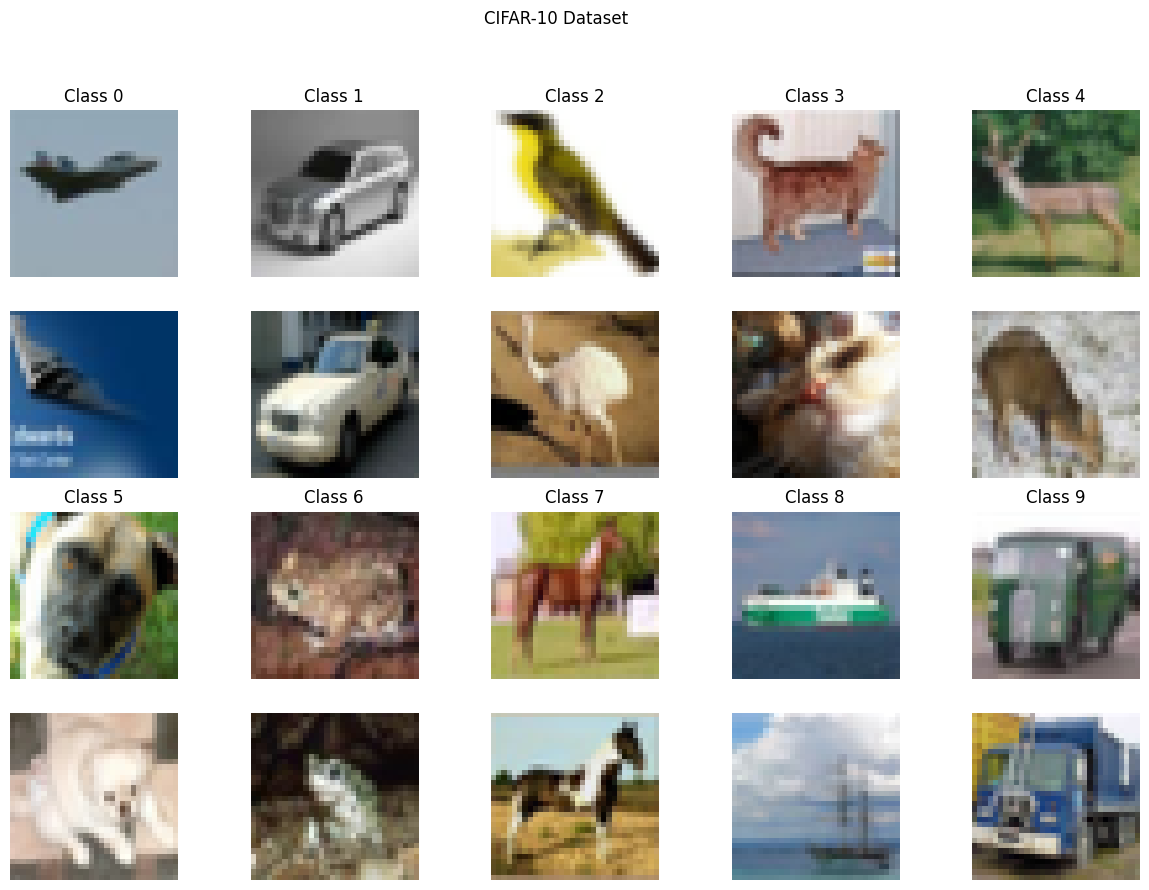

In [4]:
# Plot two images from each class.
orig_set = torchvision.datasets.CIFAR10(root=r'.\CIFAR10', train=False,
                                        download=True, transform=None)

fig, axs = plt.subplots(4, 5, figsize=(15, 10))
fig.suptitle('CIFAR-10 Dataset')
for i in range(5):
    idxs_row1 = np.random.choice(np.where(np.array(orig_set.targets) == i)[0], 2)
    idxs_row2 = np.random.choice(np.where(np.array(orig_set.targets) == i + 5)[0], 2)
    
    axs[0, i].set_title(f'Class {i}')
    axs[2, i].set_title(f'Class {i + 5}')
    for j in range(2):
        img, _ = orig_set[idxs_row1[j]]
        axs[j, i].imshow(img)
        axs[j, i].axis('off')

        img, _ = orig_set[idxs_row2[j]]
        axs[j + 2, i].imshow(img)
        axs[j + 2, i].axis('off')

plt.show()

In [5]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()

        # Extra attributes.
        self.epoch: int = 0
        self.best_acc: float = 0.
        self.costs: list[float] = []
        self.train_accs: list[float] = []
        self.val_accs: list[float] = []
    
    def forward(self, x):
        raise NotImplementedError

    def fit(self, train_loader: DataLoader, val_loader: DataLoader, 
            params_to_train: Optional[Iterator[nn.Parameter]] = None,
            num_epochs: int = 30, lr: float = 0.001, wd: float = 0.001, 
            try_cuda: bool = True, verbose: bool = True, print_stride: int = 1) -> None:
        """
        Base function for training the model.

        Args:
            train_loader (DataLoader) - The dataloader to fit the model to.
            val_loader (DataLoader) - The dataloader to validate the model on.
            params_to_train (list[nn.Parameter]) - Specify parameters to train.
            num_epochs (int) - Number of epochs.
            lr (float) - Learning rate.
            wd (float) - Weight decay.
            try_cuda (bool) - Try to use CUDA.
            verbose (bool) - Verbose flag.
            print_stride (int) - Print stride (in epochs).
        """
        use_cuda = try_cuda and torch.cuda.is_available()
        if use_cuda:
            self.cuda()
            print("Using CUDA for traininig.")
        else:
            self.cpu()
            print("Using CPU for training.")

        # Create the optimizer and criterion.
        optimizer = optim.Adam(params_to_train if params_to_train else self.parameters(), lr=lr, weight_decay=wd)
        criterion = nn.CrossEntropyLoss()

        start_epoch = self.epoch
        for epoch in range(num_epochs):
            train_true = 0.
            running_loss = 0.
            self.epoch += 1
            for mb, (x, y) in enumerate(train_loader):
                if use_cuda:
                    x, y = x.cuda(), y.cuda()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                y_hat = self(x)

                loss = criterion(y_hat, y)
                loss.backward()
                optimizer.step()

                # Calc loss
                lloss = loss.item()
                running_loss += lloss * x.size(0)

                # Calc accuracy
                train_true += (y_hat.argmax(1) == y).sum().item()

                if verbose:
                    print(f"\r[epoch: {self.epoch:02d}/{start_epoch + num_epochs:02d}", end=" ")
                    print(f"mb: {mb + 1:03d}/{len(train_loader):03d}]", end=" ")
                    print(f"loss: {lloss:.6f}", end="")

            epoch_loss = running_loss / len(train_loader.dataset)  # type: ignore
            train_acc = train_true / len(train_loader.dataset)  # type: ignore
            val_acc = self.calc_acc(val_loader, use_cuda)
            self.costs.append(epoch_loss)
            self.train_accs.append(train_acc)
            self.val_accs.append(val_acc)
                
            if verbose and (epoch % print_stride == 0 or epoch == num_epochs - 1):
                print(f"\r[epoch: {self.epoch:02d}/{start_epoch + num_epochs:02d}]", end=" ")
                print(f"[Total Loss: {epoch_loss:.6f}]", end=" ")
                print(f"[Train Acc: {100 * train_acc:.3f}%]", end=" ")
                print(f"[Val Acc: {100 * val_acc:.3f}%]")


    def calc_acc(self, data_loader: DataLoader, use_cuda: bool) -> float:
        """
        Calculates and returns the accuracy of the model on a give dataset.

        Args:
            model (nn.Module) - The model to calculate the accuracy of.
            data_loader (DataLoader) - Data loader.
            use_cuda (bool) - Use CUDA flag.

        Returns:
            float - The accuracy of the model on the dataset.
        """
        
        accuracy = Accuracy(task="multiclass", num_classes=10)
        if use_cuda:
            accuracy = accuracy.cuda()
        self.eval()
        acc = 0.
        with torch.no_grad():
            for x, y in data_loader:
                if use_cuda:
                    x, y = x.cuda(), y.cuda()
                y_hat = self(x)
                acc += accuracy(y_hat, y).item() * x.size(0)
        
        self.train()
        return acc / len(data_loader.dataset)  # type: ignore

In [6]:
class ResNet18(BaseModel):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.resnet18 = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
        for layer_name, layer in self.resnet18.named_children():
            for param in layer.parameters():
                param.requires_grad = False
        self.resnet18.fc = nn.Linear(512, NUM_CLASSES)

    def forward(self, x):
        return self.resnet18(x)

In [7]:
transfer_model = ResNet18()

In [8]:
transfer_model.fit(train_loader, valid_loader, transfer_model.resnet18.fc.parameters(),
                   num_epochs=2, lr=0.001, wd=0.001, 
                   try_cuda=True, verbose=True, print_stride=1)
transfer_model.fit(train_loader, valid_loader, transfer_model.resnet18.fc.parameters(), 
                   num_epochs=2, lr=0.0001, wd=0.001, 
                   try_cuda=True, verbose=True, print_stride=1)

Using CUDA for traininig.
[epoch: 01/02] [Total Loss: 0.896465] [Train Acc: 71.714%] [Val Acc: 78.400%]
[epoch: 02/02] [Total Loss: 0.623721] [Train Acc: 78.868%] [Val Acc: 79.150%]
Using CUDA for traininig.
[epoch: 03/04] [Total Loss: 0.580583] [Train Acc: 80.496%] [Val Acc: 79.810%]
[epoch: 04/04] [Total Loss: 0.574795] [Train Acc: 80.562%] [Val Acc: 79.970%]


In [9]:
# Find the 10 images that the model got the most wrong.
def find_most_wrong(model: nn.Module, data_loader: DataLoader, try_cuda: bool = True) -> pd.DataFrame:
    """
    Finds the indices of the 10 most wrong predictions in the dataset.

    Args:
        model (nn.Module) - The model to find the most predictions for.
        data_loader (DataLoader) - The data loader.
        try_cuda (bool) - Try CUDA flag.

    Returns:
        DataFrame - The dataframe containing information of the 10 most wrong predictions.
    """
    use_cuda = try_cuda and torch.cuda.is_available()
    results = pd.DataFrame(columns=["y", "y_hat", "ll"])
    model.eval()
    if use_cuda:
        model.cuda()
    with torch.no_grad():
        for x, y in tqdm(data_loader):
            if use_cuda:
                x = x.cuda()
            y_hat: torch.Tensor = model(x).cpu()
            results = pd.concat([results, pd.DataFrame({"y": y.tolist(), 
                                                        "y_hat": y_hat.max(1)[1].tolist(), 
                                                        "ll": y_hat.max(1)[0].tolist()})], 
                                                        ignore_index=True)
    model.train()
    return results[results["y"] != results["y_hat"]].sort_values(
        "ll", ascending=False).iloc[:10]

most_wrong = find_most_wrong(transfer_model, valid_loader, try_cuda=True)

  0%|          | 0/79 [00:00<?, ?it/s]

C:\Users\ofirp\AppData\Local\Temp\ipykernel_38432\666445339.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({"y": y.tolist(),


The 10 images with the worst prediction are: 
      y y_hat        ll
2473  0     8  6.531721
1439  9     1  6.341949
4784  0     8  6.295494
9145  1     9  6.230870
7792  9     1  6.083986
7590  2     4  6.066287
9497  3     6  5.533104
2492  8     0  5.291621
4945  9     1  5.216853
6860  0     2  5.197860


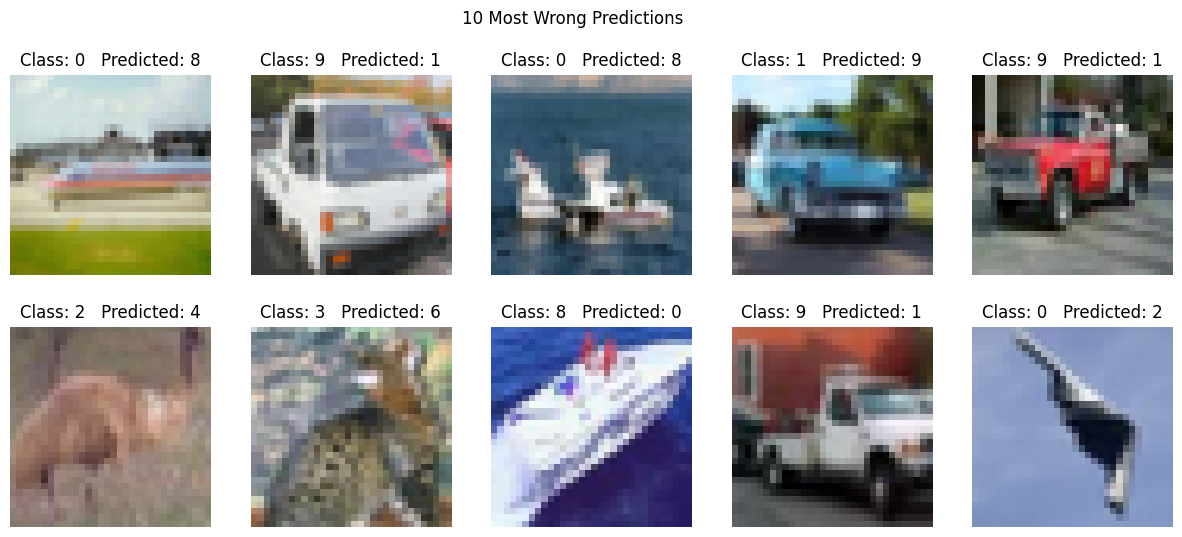

In [10]:
print(f"The 10 images with the worst prediction are: \n{most_wrong}")

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('10 Most Wrong Predictions')
for i in range(5):
    idxs_row1 = most_wrong.index.values[i]
    idxs_row2 = most_wrong.index.values[i + 5]
    img_row1, class_row1 = orig_set[idxs_row1]
    img_row2, class_row2 = orig_set[idxs_row2]

    axs[0, i].imshow(img_row1)
    axs[0, i].axis('off')
    axs[0, i].set_title(f'Class: {class_row1}   Predicted: {most_wrong["y_hat"].iloc[i]}')

    axs[1, i].imshow(img_row2)
    axs[1, i].axis('off')
    axs[1, i].set_title(f'Class: {class_row2}   Predicted: {most_wrong["y_hat"].iloc[i + 5]}')

plt.show()

We can see that the model has a hard time understanding the difference from class 1 to 9.

In [11]:
class ResidualBlock(nn.Module):
    """ResidualBlock class.
    
    This class is responsible for creating a residual block for the ResNet
    architecture.
    """
    def __init__(self, in_channels: int, out_channels: int, 
                 ksize: int = 3, stride: int = 1, padding: int = 1):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=ksize,
                                stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=ksize,
                                stride=1, padding="same", bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        
    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = torch.add(out, self.shortcut(residual))
        out = self.relu(out)
        
        return out


class CustomeResNet(BaseModel):
    """CustomeResNet class.

    Three residual blocks are used in this model to create a custom ResNet.
    """
    def __init__(self):
        super(CustomeResNet, self).__init__()

        self.residual_blocks = nn.Sequential(
            ResidualBlock(3, 32, ksize=13, stride=4, padding=5),
            ResidualBlock(32, 84, ksize=7, stride=3, padding=3),
            ResidualBlock(84, 164, ksize=5, stride=2, padding=2)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Sequential(
            nn.Linear(164, NUM_CLASSES),
        )

    def forward(self, x):
        x = self.residual_blocks(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [12]:
custom_model = CustomeResNet()

In [13]:
custom_model.fit(train_loader, valid_loader,
                num_epochs=4, lr=0.001, wd=0.0005, 
                try_cuda=True, verbose=True, print_stride=1)
custom_model.fit(train_loader, valid_loader,
                num_epochs=2, lr=0.0002, wd=0.001, 
                try_cuda=True, verbose=True, print_stride=1)
custom_model.fit(train_loader, valid_loader,
                num_epochs=1, lr=0.00005, wd=0.001, 
                try_cuda=True, verbose=True, print_stride=1)

Using CUDA for traininig.
[epoch: 01/04] [Total Loss: 1.456031] [Train Acc: 46.634%] [Val Acc: 52.810%]
[epoch: 02/04] [Total Loss: 1.029285] [Train Acc: 63.286%] [Val Acc: 64.050%]
[epoch: 03/04] [Total Loss: 0.859816] [Train Acc: 69.484%] [Val Acc: 66.360%]
[epoch: 04/04] [Total Loss: 0.735586] [Train Acc: 74.062%] [Val Acc: 69.450%]
Using CUDA for traininig.
[epoch: 05/06] [Total Loss: 0.510136] [Train Acc: 82.738%] [Val Acc: 78.450%]
[epoch: 06/06] [Total Loss: 0.445071] [Train Acc: 84.912%] [Val Acc: 80.920%]
Using CUDA for traininig.
[epoch: 07/07] [Total Loss: 0.350096] [Train Acc: 88.710%] [Val Acc: 83.070%]


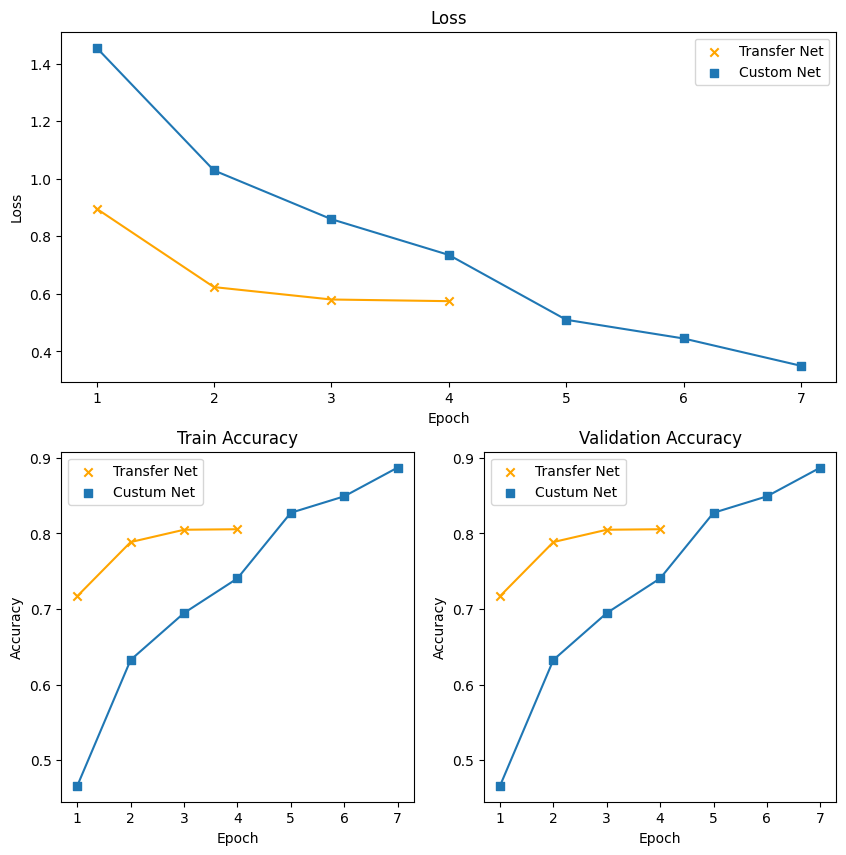

In [14]:
# Results comparison

# Plot the results.
def plot_and_scatter(epochs: range, points: list[float], label: str, 
                     color: str = "tab:blue", marker: str = "x") -> None:
    """Plots the points and scatters them."""
    plt.plot(epochs, points, color=color)
    plt.scatter(epochs, points, marker=marker, color=color, label=label)

transfer_epochs = range(1, transfer_model.epoch + 1, 1)
custom_epochs = range(1, custom_model.epoch + 1, 1)

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plot_and_scatter(transfer_epochs, transfer_model.costs, "Transfer Net", "orange", marker="x")
plot_and_scatter(custom_epochs, custom_model.costs, "Custom Net", "tab:blue", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")

plt.subplot(2, 2, 3)
plot_and_scatter(transfer_epochs, transfer_model.train_accs, label="Transfer Net", color="orange", marker="x")
plot_and_scatter(custom_epochs, custom_model.train_accs, label="Custum Net", color="tab:blue", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Train Accuracy")

plt.subplot(2, 2, 4)
plot_and_scatter(transfer_epochs, transfer_model.train_accs, label="Transfer Net", color="orange", marker="x")
plot_and_scatter(custom_epochs, custom_model.train_accs, label="Custum Net", color="tab:blue", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")

plt.show()